In [1]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from zipfile import ZipFile

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '../input/T2TrainSameSize/'

In [3]:
train = pd.read_csv(TRAIN_PATH + 'data.csv')
display(train.head())

,filename,label,fold
0,no 6.jpg,0,0
1,21 no.jpg,0,0
2,47 no.jpg,0,0
3,3 no.jpg,0,0
4,no 7.jpeg,0,0


In [4]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    print_freq=10
    num_workers=0
    model_name='resnext50_32x4d'
    size=200
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=10
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    # batch_size=32
    batch_size = 2
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=43
    target_size=1
    # target_cols=['label', 'T1']
    target_cols=['label']
    # target_cols=['T1']
    n_fold=4
    trn_fold=[0, 1, 2]
    train=True
    
if CFG.debug:
    CFG.epochs = 1

In [5]:
# ====================================================
# Library
# ====================================================
import sys
# sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
from io import BytesIO
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

In [6]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [7]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    # display(y_true)
    # display(y_pred)
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [8]:
folds = train.copy()
# Fold = GroupKFold(n_splits=CFG.n_fold)
# groups = folds['filename'].values
# for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_cols], groups)):
#   folds.loc[val_index, 'fold'] = int(n)
# folds['fold'] = folds['fold'].astype(int)
display(folds.groupby('fold').size())
display(folds)

fold
0    57
1    57
2    57
3    56
dtype: int64

,filename,label,fold
0,no 6.jpg,0,0
1,21 no.jpg,0,0
2,47 no.jpg,0,0
3,3 no.jpg,0,0
4,no 7.jpeg,0,0
...,...,...,...
222,r20_Y251.JPG,1,3
223,r20_Y99.JPG,1,3
224,r20_Y65.JPG,1,3
225,r20_Y91.jpg,1,3


In [9]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['filename'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        label = torch.tensor(self.labels[idx]).float()
        # if(label[0].item() == 1):
        #   image = cv2.imread(TRAIN_PATH + 'yes/' + file_name)
        #   # label = np.array([1]).astype(np.float)
        # else:
        #   image = cv2.imread(TRAIN_PATH + 'no/' + file_name)
        #   # label = np.array([0]).astype(np.float)
        image = cv2.imread(TRAIN_PATH + 'train/' + file_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

In [10]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

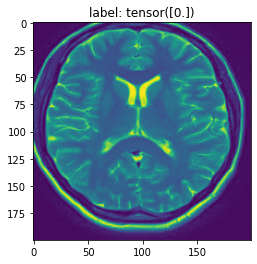

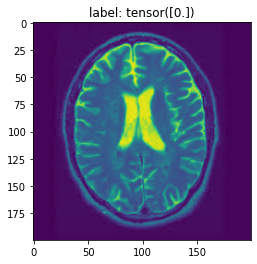

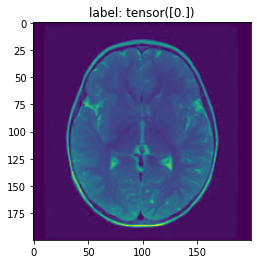

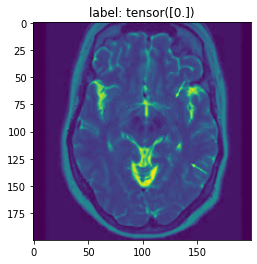

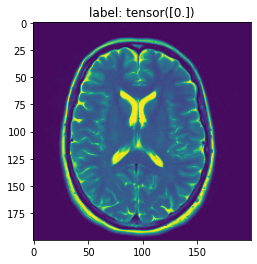

In [11]:
train_dataset = TrainDataset(folds, transform=get_transforms(data='train'))

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [12]:

tst_idx = folds[folds['fold'] == CFG.n_fold - 1].index

test_fold = folds.loc[tst_idx].reset_index(drop=True)
_test_fold = test_fold.copy(deep=True)
test_dataset = TrainDataset(_test_fold, transform=get_transforms(data='valid'))

folds = folds[folds['fold'].isin([i for i in range(CFG.n_fold - 1)])]
display(folds.groupby('fold').size())
display(folds)

fold
0    57
1    57
2    57
dtype: int64

,filename,label,fold
0,no 6.jpg,0,0
1,21 no.jpg,0,0
2,47 no.jpg,0,0
3,3 no.jpg,0,0
4,no 7.jpeg,0,0
...,...,...,...
166,r10_Y249.JPG,1,2
167,r10_Y66.JPG,1,2
168,r10_Y250.jpg,1,2
169,r10_Y36.JPG,1,2


In [13]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        if(pretrained):
          self.model.load_state_dict(torch.load('../models/resnext50_32x4d_a1h-0146ab0a.pth'))
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [14]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with autocast():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        scaler.scale(loss).backward()
        # loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [15]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()
    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score, scores = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

        """
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
        """
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']

    test_loader = DataLoader(test_dataset, 
                        batch_size=CFG.batch_size, 
                        shuffle=False, 
                        num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # test
    test_labels = test_fold[CFG.target_cols].values
    avg_test_loss, preds = valid_fn(test_loader, model, criterion, device)
    score, scores = get_score(test_labels, preds)
    
    LOGGER.info(f"========== fold: {fold} test ==========")
    LOGGER.info(f'test: avg_val_loss: {avg_test_loss:.4f}')
    LOGGER.info(f'test: Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

    return valid_folds

In [16]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.folds
    """

    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold - 1):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                # display(_oof_df)
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [17]:
main()

========== fold: 0 training ==========


Epoch: [1][0/57] Data 0.175 (0.175) Elapsed 0m 1s (remain 1m 50s) Loss: 0.7114(0.7114) Grad: nan  
Epoch: [1][10/57] Data 0.016 (0.027) Elapsed 0m 5s (remain 0m 24s) Loss: 0.6907(0.6971) Grad: 198051.6094  
Epoch: [1][20/57] Data 0.010 (0.021) Elapsed 0m 10s (remain 0m 17s) Loss: 0.6447(0.6890) Grad: 150967.5625  
Epoch: [1][30/57] Data 0.011 (0.018) Elapsed 0m 14s (remain 0m 12s) Loss: 0.5836(0.6794) Grad: 181974.0938  
Epoch: [1][40/57] Data 0.010 (0.018) Elapsed 0m 19s (remain 0m 7s) Loss: 0.6216(0.6704) Grad: 119618.3594  
Epoch: [1][50/57] Data 0.010 (0.017) Elapsed 0m 23s (remain 0m 2s) Loss: 0.9367(0.6732) Grad: 81499.2578  
Epoch: [1][56/57] Data 0.011 (0.017) Elapsed 0m 26s (remain 0m 0s) Loss: 0.6519(0.6608) Grad: 109575.1016  
EVAL: [0/15] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 1s) Loss: 0.8271(0.8271) 
EVAL: [10/15] Data 0.034 (0.033) Elapsed 0m 1s (remain 0m 0s) Loss: 0.4989(0.6798) 
EVAL: [14/15] Data 0.007 (0.031) Elapsed 0m 1s (remain 0m 0s) Loss: 0.4342(0.6433) 


Epoch 1 - avg_train_loss: 0.6608  avg_val_loss: 0.6433  time: 28s
Epoch 1 - Score: 0.7818  Scores: [0.7818]
Epoch 1 - Save Best Loss: 0.6433 Model


Epoch: [2][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 21s) Loss: 0.4729(0.4729) Grad: inf  
Epoch: [2][10/57] Data 0.010 (0.015) Elapsed 0m 5s (remain 0m 21s) Loss: 0.4707(0.6203) Grad: 108286.6484  
Epoch: [2][20/57] Data 0.010 (0.014) Elapsed 0m 9s (remain 0m 16s) Loss: 0.6073(0.5934) Grad: 622378.6250  
Epoch: [2][30/57] Data 0.011 (0.015) Elapsed 0m 14s (remain 0m 12s) Loss: 0.5017(0.5641) Grad: 121394.7891  
Epoch: [2][40/57] Data 0.010 (0.014) Elapsed 0m 19s (remain 0m 7s) Loss: 0.3937(0.5908) Grad: 80676.4453  
Epoch: [2][50/57] Data 0.010 (0.014) Elapsed 0m 24s (remain 0m 2s) Loss: 0.4902(0.5904) Grad: 98449.9453  
Epoch: [2][56/57] Data 0.008 (0.014) Elapsed 0m 26s (remain 0m 0s) Loss: 1.2647(0.6075) Grad: 219844.1875  
EVAL: [0/15] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 1s) Loss: 0.9100(0.9100) 
EVAL: [10/15] Data 0.031 (0.034) Elapsed 0m 1s (remain 0m 0s) Loss: 0.3764(0.6552) 
EVAL: [14/15] Data 0.016 (0.034) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3499(0.5834) 


Epoch 2 - avg_train_loss: 0.6075  avg_val_loss: 0.5834  time: 29s
Epoch 2 - Score: 0.8935  Scores: [0.8935]
Epoch 2 - Save Best Loss: 0.5834 Model


Epoch: [3][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 21s) Loss: 0.3388(0.3388) Grad: inf  
Epoch: [3][10/57] Data 0.009 (0.012) Elapsed 0m 5s (remain 0m 22s) Loss: 0.3735(0.5480) Grad: 92893.0859  
Epoch: [3][20/57] Data 0.009 (0.013) Elapsed 0m 10s (remain 0m 17s) Loss: 0.4858(0.6267) Grad: 130810.4922  
Epoch: [3][30/57] Data 0.009 (0.013) Elapsed 0m 15s (remain 0m 13s) Loss: 0.3158(0.5878) Grad: 129783.3047  
Epoch: [3][40/57] Data 0.011 (0.014) Elapsed 0m 20s (remain 0m 8s) Loss: 0.8500(0.5979) Grad: 269123.0000  
Epoch: [3][50/57] Data 0.027 (0.014) Elapsed 0m 26s (remain 0m 3s) Loss: 0.3148(0.6002) Grad: 20889.1895  
Epoch: [3][56/57] Data 0.014 (0.014) Elapsed 0m 29s (remain 0m 0s) Loss: 0.4262(0.5968) Grad: 47079.8164  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 1s) Loss: 0.8049(0.8049) 
EVAL: [10/15] Data 0.041 (0.031) Elapsed 0m 1s (remain 0m 0s) Loss: 0.3349(0.6035) 
EVAL: [14/15] Data 0.006 (0.031) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2720(0.5429) 


Epoch 3 - avg_train_loss: 0.5968  avg_val_loss: 0.5429  time: 32s
Epoch 3 - Score: 0.9312  Scores: [0.9312]
Epoch 3 - Save Best Loss: 0.5429 Model


Epoch: [4][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 21s) Loss: 0.3065(0.3065) Grad: inf  
Epoch: [4][10/57] Data 0.013 (0.017) Elapsed 0m 5s (remain 0m 24s) Loss: 0.2436(0.4252) Grad: 34149.3867  
Epoch: [4][20/57] Data 0.016 (0.017) Elapsed 0m 11s (remain 0m 19s) Loss: 0.4793(0.6629) Grad: 114827.3516  
Epoch: [4][30/57] Data 0.010 (0.016) Elapsed 0m 16s (remain 0m 14s) Loss: 0.2367(0.6619) Grad: 37461.5312  
Epoch: [4][40/57] Data 0.015 (0.017) Elapsed 0m 22s (remain 0m 8s) Loss: 0.3541(0.6357) Grad: 48049.0586  
Epoch: [4][50/57] Data 0.016 (0.016) Elapsed 0m 28s (remain 0m 3s) Loss: 0.1869(0.5844) Grad: 73353.0234  
Epoch: [4][56/57] Data 0.014 (0.017) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2083(0.5790) Grad: 22905.3125  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 1s) Loss: 0.7902(0.7902) 
EVAL: [10/15] Data 0.038 (0.034) Elapsed 0m 1s (remain 0m 0s) Loss: 0.2217(0.5497) 
EVAL: [14/15] Data 0.010 (0.032) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1966(0.4750) 


Epoch 4 - avg_train_loss: 0.5790  avg_val_loss: 0.4750  time: 34s
Epoch 4 - Score: 0.9727  Scores: [0.9727]
Epoch 4 - Save Best Loss: 0.4750 Model


Epoch: [5][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 30s) Loss: 0.1783(0.1783) Grad: inf  
Epoch: [5][10/57] Data 0.010 (0.019) Elapsed 0m 5s (remain 0m 25s) Loss: 0.2080(0.3525) Grad: 166917.7344  
Epoch: [5][20/57] Data 0.018 (0.019) Elapsed 0m 11s (remain 0m 19s) Loss: 0.3342(0.5136) Grad: 20624.8750  
Epoch: [5][30/57] Data 0.015 (0.018) Elapsed 0m 17s (remain 0m 14s) Loss: 0.3306(0.5281) Grad: 29476.0039  
Epoch: [5][40/57] Data 0.014 (0.018) Elapsed 0m 22s (remain 0m 8s) Loss: 1.7567(0.5364) Grad: 401334.8125  
Epoch: [5][50/57] Data 0.010 (0.017) Elapsed 0m 28s (remain 0m 3s) Loss: 1.8911(0.5615) Grad: 144878.7344  
Epoch: [5][56/57] Data 0.013 (0.017) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1818(0.5357) Grad: 33786.3398  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 2s) Loss: 0.6752(0.6752) 
EVAL: [10/15] Data 0.023 (0.028) Elapsed 0m 1s (remain 0m 0s) Loss: 0.2465(0.5395) 
EVAL: [14/15] Data 0.007 (0.027) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2059(0.4795) 


Epoch 5 - avg_train_loss: 0.5357  avg_val_loss: 0.4795  time: 34s
Epoch 5 - Score: 0.9234  Scores: [0.9234]


Epoch: [6][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 26s) Loss: 0.1949(0.1949) Grad: inf  
Epoch: [6][10/57] Data 0.013 (0.014) Elapsed 0m 5s (remain 0m 24s) Loss: 1.7430(0.6300) Grad: 426294.8750  
Epoch: [6][20/57] Data 0.014 (0.014) Elapsed 0m 11s (remain 0m 19s) Loss: 0.3499(0.5517) Grad: 74922.1172  
Epoch: [6][30/57] Data 0.014 (0.014) Elapsed 0m 17s (remain 0m 14s) Loss: 0.3246(0.5292) Grad: 32594.7812  
Epoch: [6][40/57] Data 0.010 (0.015) Elapsed 0m 22s (remain 0m 8s) Loss: 0.3054(0.5512) Grad: 30061.3066  
Epoch: [6][50/57] Data 0.014 (0.015) Elapsed 0m 28s (remain 0m 3s) Loss: 0.4922(0.5609) Grad: 120354.7344  
Epoch: [6][56/57] Data 0.012 (0.015) Elapsed 0m 31s (remain 0m 0s) Loss: 0.3372(0.5574) Grad: 68674.9531  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 1s) Loss: 0.7620(0.7620) 
EVAL: [10/15] Data 0.027 (0.028) Elapsed 0m 1s (remain 0m 0s) Loss: 0.1443(0.5459) 
EVAL: [14/15] Data 0.006 (0.026) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2198(0.4706) 


Epoch 6 - avg_train_loss: 0.5574  avg_val_loss: 0.4706  time: 34s
Epoch 6 - Score: 0.9494  Scores: [0.9494]
Epoch 6 - Save Best Loss: 0.4706 Model


Epoch: [7][0/57] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 24s) Loss: 1.8386(1.8386) Grad: nan  
Epoch: [7][10/57] Data 0.011 (0.013) Elapsed 0m 6s (remain 0m 25s) Loss: 0.9867(0.6508) Grad: 383293.5000  
Epoch: [7][20/57] Data 0.009 (0.014) Elapsed 0m 11s (remain 0m 19s) Loss: 0.6744(0.5304) Grad: 211101.7656  
Epoch: [7][30/57] Data 0.008 (0.013) Elapsed 0m 17s (remain 0m 14s) Loss: 0.4471(0.4949) Grad: 165345.9062  
Epoch: [7][40/57] Data 0.011 (0.013) Elapsed 0m 22s (remain 0m 8s) Loss: 0.2929(0.5058) Grad: 14110.1816  
Epoch: [7][50/57] Data 0.013 (0.014) Elapsed 0m 28s (remain 0m 3s) Loss: 1.5735(0.5051) Grad: 118289.0703  
Epoch: [7][56/57] Data 0.010 (0.014) Elapsed 0m 31s (remain 0m 0s) Loss: 0.3137(0.4738) Grad: 31439.5996  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 1s) Loss: 0.6249(0.6249) 
EVAL: [10/15] Data 0.042 (0.029) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3548(0.5331) 
EVAL: [14/15] Data 0.025 (0.032) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1760(0.4872) 


Epoch 7 - avg_train_loss: 0.4738  avg_val_loss: 0.4872  time: 34s
Epoch 7 - Score: 0.9494  Scores: [0.9494]


Epoch: [8][0/57] Data 0.060 (0.060) Elapsed 0m 0s (remain 0m 29s) Loss: 1.8112(1.8112) Grad: nan  
Epoch: [8][10/57] Data 0.011 (0.024) Elapsed 0m 6s (remain 0m 25s) Loss: 0.1745(0.8439) Grad: 27088.5195  
Epoch: [8][20/57] Data 0.010 (0.019) Elapsed 0m 11s (remain 0m 20s) Loss: 0.1553(0.7596) Grad: 16613.8242  
Epoch: [8][30/57] Data 0.010 (0.018) Elapsed 0m 17s (remain 0m 14s) Loss: 0.1959(0.7222) Grad: 73052.9297  
Epoch: [8][40/57] Data 0.007 (0.016) Elapsed 0m 22s (remain 0m 8s) Loss: 0.1685(0.6469) Grad: 28355.1543  
Epoch: [8][50/57] Data 0.008 (0.016) Elapsed 0m 28s (remain 0m 3s) Loss: 1.7832(0.6069) Grad: 181647.8594  
Epoch: [8][56/57] Data 0.009 (0.016) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2367(0.5707) Grad: 67579.7891  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 1s) Loss: 0.6348(0.6348) 
EVAL: [10/15] Data 0.026 (0.024) Elapsed 0m 1s (remain 0m 0s) Loss: 0.2476(0.5213) 
EVAL: [14/15] Data 0.008 (0.025) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1879(0.4715) 


Epoch 8 - avg_train_loss: 0.5707  avg_val_loss: 0.4715  time: 34s
Epoch 8 - Score: 0.9247  Scores: [0.9247]


Epoch: [9][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 27s) Loss: 0.3133(0.3133) Grad: inf  
Epoch: [9][10/57] Data 0.011 (0.012) Elapsed 0m 6s (remain 0m 25s) Loss: 0.3258(0.5052) Grad: 79630.8672  
Epoch: [9][20/57] Data 0.009 (0.012) Elapsed 0m 11s (remain 0m 20s) Loss: 0.4720(0.4752) Grad: 264302.9375  
Epoch: [9][30/57] Data 0.017 (0.013) Elapsed 0m 17s (remain 0m 14s) Loss: 0.1782(0.4292) Grad: 24670.1113  
Epoch: [9][40/57] Data 0.011 (0.013) Elapsed 0m 22s (remain 0m 8s) Loss: 0.3190(0.4659) Grad: 62981.6680  
Epoch: [9][50/57] Data 0.012 (0.013) Elapsed 0m 28s (remain 0m 3s) Loss: 0.2570(0.4242) Grad: 22576.7969  
Epoch: [9][56/57] Data 0.009 (0.013) Elapsed 0m 31s (remain 0m 0s) Loss: 0.9429(0.4481) Grad: 319641.7812  
EVAL: [0/15] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 1s) Loss: 0.5763(0.5763) 
EVAL: [10/15] Data 0.029 (0.025) Elapsed 0m 1s (remain 0m 0s) Loss: 0.1765(0.4836) 
EVAL: [14/15] Data 0.008 (0.027) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1391(0.4256) 


Epoch 9 - avg_train_loss: 0.4481  avg_val_loss: 0.4256  time: 34s
Epoch 9 - Score: 0.9325  Scores: [0.9325]
Epoch 9 - Save Best Loss: 0.4256 Model


Epoch: [10][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 23s) Loss: 0.1641(0.1641) Grad: inf  
Epoch: [10][10/57] Data 0.009 (0.011) Elapsed 0m 6s (remain 0m 25s) Loss: 0.2316(0.5980) Grad: 35464.7891  
Epoch: [10][20/57] Data 0.012 (0.013) Elapsed 0m 11s (remain 0m 20s) Loss: 0.1428(0.5063) Grad: 35872.4805  
Epoch: [10][30/57] Data 0.015 (0.013) Elapsed 0m 17s (remain 0m 14s) Loss: 0.1503(0.5258) Grad: 56786.0547  
Epoch: [10][40/57] Data 0.009 (0.013) Elapsed 0m 23s (remain 0m 9s) Loss: 0.1560(0.4951) Grad: 51901.2812  
Epoch: [10][50/57] Data 0.009 (0.013) Elapsed 0m 29s (remain 0m 3s) Loss: 1.8441(0.5091) Grad: 274587.3125  
Epoch: [10][56/57] Data 0.014 (0.013) Elapsed 0m 32s (remain 0m 0s) Loss: 0.2872(0.4787) Grad: 94804.4922  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 1s) Loss: 0.5660(0.5660) 
EVAL: [10/15] Data 0.021 (0.026) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2757(0.4774) 
EVAL: [14/15] Data 0.008 (0.025) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1701(0.4284)

Epoch 10 - avg_train_loss: 0.4787  avg_val_loss: 0.4284  time: 35s
Epoch 10 - Score: 0.8961  Scores: [0.8961]


EVAL: [0/28] Data 0.009 (0.009) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3583(0.3583) 
EVAL: [10/28] Data 0.011 (0.014) Elapsed 0m 0s (remain 0m 1s) Loss: 0.6117(0.4353) 
EVAL: [20/28] Data 0.015 (0.014) Elapsed 0m 1s (remain 0m 0s) Loss: 0.7505(0.4241) 
EVAL: [27/28] Data 0.017 (0.014) Elapsed 0m 2s (remain 0m 0s) Loss: 0.4392(0.4239) 


========== fold: 0 test ==========
test: avg_val_loss: 0.4239
test: Score: 0.9728  Scores: [0.9728]
========== fold: 0 result ==========
Score: 0.9325  Scores: [0.9325]
========== fold: 1 training ==========


Epoch: [1][0/57] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 22s) Loss: 0.6873(0.6873) Grad: nan  
Epoch: [1][10/57] Data 0.009 (0.011) Elapsed 0m 5s (remain 0m 24s) Loss: 0.6862(0.6973) Grad: 277154.5312  
Epoch: [1][20/57] Data 0.013 (0.012) Elapsed 0m 11s (remain 0m 19s) Loss: 0.6406(0.6868) Grad: 101450.9219  
Epoch: [1][30/57] Data 0.007 (0.012) Elapsed 0m 17s (remain 0m 14s) Loss: 0.7558(0.6809) Grad: 353511.7188  
Epoch: [1][40/57] Data 0.011 (0.013) Elapsed 0m 22s (remain 0m 8s) Loss: 0.6690(0.6767) Grad: 110290.8828  
Epoch: [1][50/57] Data 0.012 (0.013) Elapsed 0m 28s (remain 0m 3s) Loss: 0.6476(0.6777) Grad: 119980.4609  
Epoch: [1][56/57] Data 0.010 (0.013) Elapsed 0m 31s (remain 0m 0s) Loss: 0.7160(0.6735) Grad: 78345.1250  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 1s) Loss: 0.9463(0.9463) 
EVAL: [10/15] Data 0.021 (0.024) Elapsed 0m 1s (remain 0m 0s) Loss: 0.5170(0.6773) 
EVAL: [14/15] Data 0.005 (0.024) Elapsed 0m 2s (remain 0m 0s) Loss: 0.5195(0.6381) 


Epoch 1 - avg_train_loss: 0.6735  avg_val_loss: 0.6381  time: 34s
Epoch 1 - Score: 0.7162  Scores: [0.7162]
Epoch 1 - Save Best Loss: 0.6381 Model


Epoch: [2][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 25s) Loss: 0.9313(0.9313) Grad: inf  
Epoch: [2][10/57] Data 0.007 (0.016) Elapsed 0m 6s (remain 0m 26s) Loss: 0.9359(0.7287) Grad: 298700.1875  
Epoch: [2][20/57] Data 0.011 (0.015) Elapsed 0m 11s (remain 0m 20s) Loss: 0.4764(0.6511) Grad: 227722.1562  
Epoch: [2][30/57] Data 0.010 (0.014) Elapsed 0m 17s (remain 0m 14s) Loss: 0.9952(0.6718) Grad: 143680.2500  
Epoch: [2][40/57] Data 0.009 (0.014) Elapsed 0m 23s (remain 0m 9s) Loss: 0.4535(0.6383) Grad: 60043.0117  
Epoch: [2][50/57] Data 0.011 (0.014) Elapsed 0m 28s (remain 0m 3s) Loss: 0.3895(0.6103) Grad: 59226.9609  
Epoch: [2][56/57] Data 0.008 (0.014) Elapsed 0m 32s (remain 0m 0s) Loss: 0.3685(0.6107) Grad: 29377.5996  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 1s) Loss: 0.9449(0.9449) 
EVAL: [10/15] Data 0.026 (0.026) Elapsed 0m 1s (remain 0m 0s) Loss: 0.3452(0.6569) 
EVAL: [14/15] Data 0.007 (0.035) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3238(0.5916) 


Epoch 2 - avg_train_loss: 0.6107  avg_val_loss: 0.5916  time: 35s
Epoch 2 - Score: 0.8081  Scores: [0.8081]
Epoch 2 - Save Best Loss: 0.5916 Model


Epoch: [3][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 23s) Loss: 0.8160(0.8160) Grad: nan  
Epoch: [3][10/57] Data 0.009 (0.012) Elapsed 0m 6s (remain 0m 27s) Loss: 0.3383(0.4574) Grad: 92419.7031  
Epoch: [3][20/57] Data 0.010 (0.013) Elapsed 0m 12s (remain 0m 21s) Loss: 0.5715(0.5700) Grad: 421888.1562  
Epoch: [3][30/57] Data 0.010 (0.013) Elapsed 0m 18s (remain 0m 15s) Loss: 1.2649(0.5778) Grad: 379752.2188  
Epoch: [3][40/57] Data 0.009 (0.013) Elapsed 0m 24s (remain 0m 9s) Loss: 0.4688(0.5771) Grad: 126467.8047  
Epoch: [3][50/57] Data 0.010 (0.014) Elapsed 0m 30s (remain 0m 3s) Loss: 0.4727(0.5861) Grad: 137839.0469  
Epoch: [3][56/57] Data 0.021 (0.015) Elapsed 0m 35s (remain 0m 0s) Loss: 0.5470(0.5867) Grad: 270031.8750  
EVAL: [0/15] Data 0.076 (0.076) Elapsed 0m 0s (remain 0m 2s) Loss: 0.9879(0.9879) 
EVAL: [10/15] Data 0.051 (0.086) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2633(0.6437) 
EVAL: [14/15] Data 0.012 (0.071) Elapsed 0m 3s (remain 0m 0s) Loss: 0.2219(0.5694) 


Epoch 3 - avg_train_loss: 0.5867  avg_val_loss: 0.5694  time: 39s
Epoch 3 - Score: 0.7743  Scores: [0.7743]
Epoch 3 - Save Best Loss: 0.5694 Model


Epoch: [4][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 25s) Loss: 0.6291(0.6291) Grad: nan  
Epoch: [4][10/57] Data 0.013 (0.015) Elapsed 0m 6s (remain 0m 27s) Loss: 0.4173(0.5866) Grad: 223593.6562  
Epoch: [4][20/57] Data 0.011 (0.019) Elapsed 0m 13s (remain 0m 22s) Loss: 0.2791(0.5344) Grad: 120564.5703  
Epoch: [4][30/57] Data 0.010 (0.017) Elapsed 0m 19s (remain 0m 15s) Loss: 0.2915(0.5680) Grad: 45609.6719  
Epoch: [4][40/57] Data 0.012 (0.018) Elapsed 0m 25s (remain 0m 9s) Loss: 0.2638(0.5424) Grad: 40164.3281  
Epoch: [4][50/57] Data 0.011 (0.018) Elapsed 0m 31s (remain 0m 3s) Loss: 1.4456(0.6154) Grad: 123779.5312  
Epoch: [4][56/57] Data 0.023 (0.023) Elapsed 0m 37s (remain 0m 0s) Loss: 0.3187(0.5809) Grad: 24668.3906  
EVAL: [0/15] Data 0.071 (0.071) Elapsed 0m 0s (remain 0m 2s) Loss: 0.9148(0.9148) 
EVAL: [10/15] Data 0.067 (0.077) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1773(0.6009) 
EVAL: [14/15] Data 0.010 (0.071) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1744(0.5252) 


Epoch 4 - avg_train_loss: 0.5809  avg_val_loss: 0.5252  time: 41s
Epoch 4 - Score: 0.8581  Scores: [0.8581]
Epoch 4 - Save Best Loss: 0.5252 Model


Epoch: [5][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 26s) Loss: 0.2594(0.2594) Grad: inf  
Epoch: [5][10/57] Data 0.016 (0.012) Elapsed 0m 6s (remain 0m 27s) Loss: 0.3267(0.4794) Grad: 169300.3125  
Epoch: [5][20/57] Data 0.010 (0.013) Elapsed 0m 12s (remain 0m 22s) Loss: 0.4923(0.5617) Grad: 330479.3438  
Epoch: [5][30/57] Data 0.013 (0.014) Elapsed 0m 18s (remain 0m 15s) Loss: 0.3973(0.6058) Grad: 126178.8750  
Epoch: [5][40/57] Data 0.009 (0.014) Elapsed 0m 25s (remain 0m 9s) Loss: 0.2866(0.5328) Grad: 86562.3359  
Epoch: [5][50/57] Data 0.017 (0.014) Elapsed 0m 31s (remain 0m 3s) Loss: 0.3302(0.5143) Grad: 44928.5352  
Epoch: [5][56/57] Data 0.009 (0.014) Elapsed 0m 35s (remain 0m 0s) Loss: 0.3160(0.4924) Grad: 58004.5938  
EVAL: [0/15] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 2s) Loss: 0.8516(0.8516) 
EVAL: [10/15] Data 0.030 (0.028) Elapsed 0m 1s (remain 0m 0s) Loss: 0.1552(0.5762) 
EVAL: [14/15] Data 0.027 (0.042) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1769(0.5071) 


Epoch 5 - avg_train_loss: 0.4924  avg_val_loss: 0.5071  time: 38s
Epoch 5 - Score: 0.8851  Scores: [0.8851]
Epoch 5 - Save Best Loss: 0.5071 Model


Epoch: [6][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 33s) Loss: 0.2472(0.2472) Grad: inf  
Epoch: [6][10/57] Data 0.009 (0.011) Elapsed 0m 6s (remain 0m 28s) Loss: 0.5811(0.5327) Grad: inf  
Epoch: [6][20/57] Data 0.008 (0.012) Elapsed 0m 13s (remain 0m 22s) Loss: 0.9938(0.5991) Grad: 281176.0625  
Epoch: [6][30/57] Data 0.009 (0.013) Elapsed 0m 19s (remain 0m 16s) Loss: 0.3165(0.5080) Grad: 47506.2969  
Epoch: [6][40/57] Data 0.012 (0.013) Elapsed 0m 25s (remain 0m 9s) Loss: 0.2110(0.5276) Grad: 41405.7852  
Epoch: [6][50/57] Data 0.008 (0.013) Elapsed 0m 31s (remain 0m 3s) Loss: 0.2971(0.5477) Grad: 63944.4570  
Epoch: [6][56/57] Data 0.013 (0.013) Elapsed 0m 35s (remain 0m 0s) Loss: 1.6738(0.5760) Grad: 190780.8906  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 2s) Loss: 1.0414(1.0414) 
EVAL: [10/15] Data 0.029 (0.026) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1590(0.6079) 
EVAL: [14/15] Data 0.008 (0.025) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1171(0.5157) 


Epoch 6 - avg_train_loss: 0.5760  avg_val_loss: 0.5157  time: 38s
Epoch 6 - Score: 0.8730  Scores: [0.873]


Epoch: [7][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 29s) Loss: 1.4638(1.4638) Grad: nan  
Epoch: [7][10/57] Data 0.009 (0.011) Elapsed 0m 6s (remain 0m 27s) Loss: 0.3437(0.6932) Grad: 59943.6953  
Epoch: [7][20/57] Data 0.009 (0.012) Elapsed 0m 12s (remain 0m 21s) Loss: 0.4151(0.7044) Grad: 47603.9375  
Epoch: [7][30/57] Data 0.011 (0.013) Elapsed 0m 18s (remain 0m 15s) Loss: 1.5082(0.6149) Grad: 396266.1562  
Epoch: [7][40/57] Data 0.013 (0.015) Elapsed 0m 25s (remain 0m 9s) Loss: 0.2340(0.5736) Grad: 40164.0703  
Epoch: [7][50/57] Data 0.009 (0.015) Elapsed 0m 31s (remain 0m 3s) Loss: 0.3039(0.5422) Grad: 49828.9688  
Epoch: [7][56/57] Data 0.016 (0.015) Elapsed 0m 35s (remain 0m 0s) Loss: 0.6331(0.5473) Grad: 134632.7656  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 1s) Loss: 0.7514(0.7514) 
EVAL: [10/15] Data 0.028 (0.028) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1818(0.5570) 
EVAL: [14/15] Data 0.010 (0.030) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1433(0.4911) 


Epoch 7 - avg_train_loss: 0.5473  avg_val_loss: 0.4911  time: 38s
Epoch 7 - Score: 0.8973  Scores: [0.8973]
Epoch 7 - Save Best Loss: 0.4911 Model


Epoch: [8][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 26s) Loss: 0.3071(0.3071) Grad: inf  
Epoch: [8][10/57] Data 0.009 (0.011) Elapsed 0m 6s (remain 0m 27s) Loss: 0.3015(0.4382) Grad: 244381.8438  
Epoch: [8][20/57] Data 0.010 (0.014) Elapsed 0m 12s (remain 0m 21s) Loss: 1.0715(0.4373) Grad: 204755.5625  
Epoch: [8][30/57] Data 0.012 (0.014) Elapsed 0m 18s (remain 0m 15s) Loss: 0.3406(0.4902) Grad: 24770.5234  
Epoch: [8][40/57] Data 0.011 (0.013) Elapsed 0m 24s (remain 0m 9s) Loss: 0.3081(0.4720) Grad: 24673.4648  
Epoch: [8][50/57] Data 0.016 (0.013) Elapsed 0m 31s (remain 0m 3s) Loss: 0.3837(0.5354) Grad: 38334.8945  
Epoch: [8][56/57] Data 0.016 (0.014) Elapsed 0m 34s (remain 0m 0s) Loss: 0.3503(0.5594) Grad: 29440.2422  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 1s) Loss: 1.0910(1.0910) 
EVAL: [10/15] Data 0.028 (0.030) Elapsed 0m 1s (remain 0m 0s) Loss: 0.1160(0.6230) 
EVAL: [14/15] Data 0.007 (0.027) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0938(0.5234) 


Epoch 8 - avg_train_loss: 0.5594  avg_val_loss: 0.5234  time: 37s
Epoch 8 - Score: 0.8851  Scores: [0.8851]


Epoch: [9][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 29s) Loss: 0.2850(0.2850) Grad: inf  
Epoch: [9][10/57] Data 0.013 (0.012) Elapsed 0m 6s (remain 0m 27s) Loss: 1.5154(0.7250) Grad: inf  
Epoch: [9][20/57] Data 0.009 (0.011) Elapsed 0m 12s (remain 0m 21s) Loss: 1.4860(0.6667) Grad: 385875.2500  
Epoch: [9][30/57] Data 0.010 (0.012) Elapsed 0m 18s (remain 0m 15s) Loss: 0.3374(0.6977) Grad: 64558.5430  
Epoch: [9][40/57] Data 0.012 (0.012) Elapsed 0m 24s (remain 0m 9s) Loss: 0.1941(0.6007) Grad: 22236.1816  
Epoch: [9][50/57] Data 0.016 (0.013) Elapsed 0m 30s (remain 0m 3s) Loss: 0.3973(0.5406) Grad: 53604.5078  
Epoch: [9][56/57] Data 0.010 (0.013) Elapsed 0m 34s (remain 0m 0s) Loss: 1.7241(0.5650) Grad: 141462.7969  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 2s) Loss: 0.8834(0.8834) 
EVAL: [10/15] Data 0.025 (0.031) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1281(0.5634) 
EVAL: [14/15] Data 0.006 (0.030) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1420(0.4779) 


Epoch 9 - avg_train_loss: 0.5650  avg_val_loss: 0.4779  time: 37s
Epoch 9 - Score: 0.9162  Scores: [0.9162]
Epoch 9 - Save Best Loss: 0.4779 Model


Epoch: [10][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 25s) Loss: 0.1990(0.1990) Grad: inf  
Epoch: [10][10/57] Data 0.010 (0.012) Elapsed 0m 6s (remain 0m 25s) Loss: 0.8237(0.9974) Grad: 179022.4688  
Epoch: [10][20/57] Data 0.008 (0.013) Elapsed 0m 11s (remain 0m 20s) Loss: 0.2384(0.7105) Grad: 17893.8477  
Epoch: [10][30/57] Data 0.011 (0.013) Elapsed 0m 17s (remain 0m 15s) Loss: 0.2601(0.5940) Grad: 34334.3359  
Epoch: [10][40/57] Data 0.014 (0.014) Elapsed 0m 24s (remain 0m 9s) Loss: 1.4212(0.5480) Grad: 282828.1562  
Epoch: [10][50/57] Data 0.008 (0.014) Elapsed 0m 30s (remain 0m 3s) Loss: 2.0897(0.5886) Grad: 207633.3281  
Epoch: [10][56/57] Data 0.009 (0.014) Elapsed 0m 34s (remain 0m 0s) Loss: 0.3281(0.5523) Grad: 72394.7188  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 4s) Loss: 1.0322(1.0322) 
EVAL: [10/15] Data 0.031 (0.039) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1172(0.5806) 
EVAL: [14/15] Data 0.006 (0.037) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0865(0.475

Epoch 10 - avg_train_loss: 0.5523  avg_val_loss: 0.4751  time: 37s
Epoch 10 - Score: 0.9311  Scores: [0.9311]
Epoch 10 - Save Best Loss: 0.4751 Model


EVAL: [0/28] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 1s) Loss: 0.5139(0.5139) 
EVAL: [10/28] Data 0.016 (0.012) Elapsed 0m 1s (remain 0m 1s) Loss: 0.9120(0.7471) 
EVAL: [20/28] Data 0.015 (0.014) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3575(0.4889) 
EVAL: [27/28] Data 0.014 (0.014) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1322(0.4100) 


========== fold: 1 test ==========
test: avg_val_loss: 0.4100
test: Score: 0.9524  Scores: [0.9524]
========== fold: 1 result ==========
Score: 0.9311  Scores: [0.9311]
========== fold: 2 training ==========


Epoch: [1][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 21s) Loss: 0.6763(0.6763) Grad: nan  
Epoch: [1][10/57] Data 0.009 (0.012) Elapsed 0m 6s (remain 0m 27s) Loss: 0.6937(0.6920) Grad: 273295.3125  
Epoch: [1][20/57] Data 0.012 (0.013) Elapsed 0m 12s (remain 0m 21s) Loss: 0.7472(0.6872) Grad: 195088.6719  
Epoch: [1][30/57] Data 0.010 (0.013) Elapsed 0m 18s (remain 0m 15s) Loss: 0.5900(0.6747) Grad: 119734.3516  
Epoch: [1][40/57] Data 0.008 (0.013) Elapsed 0m 25s (remain 0m 9s) Loss: 0.8418(0.6796) Grad: 106092.8594  
Epoch: [1][50/57] Data 0.013 (0.014) Elapsed 0m 31s (remain 0m 3s) Loss: 0.6697(0.6571) Grad: 142017.8281  
Epoch: [1][56/57] Data 0.018 (0.015) Elapsed 0m 34s (remain 0m 0s) Loss: 0.9926(0.6662) Grad: 134384.6719  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 1s) Loss: 0.9229(0.9229) 
EVAL: [10/15] Data 0.032 (0.039) Elapsed 0m 1s (remain 0m 0s) Loss: 0.4162(0.6818) 
EVAL: [14/15] Data 0.009 (0.037) Elapsed 0m 2s (remain 0m 0s) Loss: 0.4573(0.6247) 


Epoch 1 - avg_train_loss: 0.6662  avg_val_loss: 0.6247  time: 38s
Epoch 1 - Score: 0.8005  Scores: [0.8005]
Epoch 1 - Save Best Loss: 0.6247 Model


Epoch: [2][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 25s) Loss: 0.5906(0.5906) Grad: inf  
Epoch: [2][10/57] Data 0.008 (0.011) Elapsed 0m 6s (remain 0m 27s) Loss: 0.7061(0.6469) Grad: 489291.4688  
Epoch: [2][20/57] Data 0.010 (0.012) Elapsed 0m 13s (remain 0m 22s) Loss: 0.6238(0.6461) Grad: 325029.7188  
Epoch: [2][30/57] Data 0.011 (0.013) Elapsed 0m 19s (remain 0m 16s) Loss: 0.4540(0.6043) Grad: 73967.8906  
Epoch: [2][40/57] Data 0.011 (0.013) Elapsed 0m 25s (remain 0m 9s) Loss: 0.5411(0.6027) Grad: 145259.3438  
Epoch: [2][50/57] Data 0.010 (0.013) Elapsed 0m 31s (remain 0m 3s) Loss: 0.5073(0.5992) Grad: 105908.3906  
Epoch: [2][56/57] Data 0.009 (0.013) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4519(0.5945) Grad: 59607.3906  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 2s) Loss: 0.9981(0.9981) 
EVAL: [10/15] Data 0.024 (0.028) Elapsed 0m 1s (remain 0m 0s) Loss: 0.2703(0.6920) 
EVAL: [14/15] Data 0.008 (0.039) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3310(0.6017) 


Epoch 2 - avg_train_loss: 0.5945  avg_val_loss: 0.6017  time: 38s
Epoch 2 - Score: 0.7634  Scores: [0.7634]
Epoch 2 - Save Best Loss: 0.6017 Model


Epoch: [3][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 24s) Loss: 0.4877(0.4877) Grad: inf  
Epoch: [3][10/57] Data 0.012 (0.012) Elapsed 0m 6s (remain 0m 27s) Loss: 0.4790(0.6197) Grad: 218457.1719  
Epoch: [3][20/57] Data 0.016 (0.014) Elapsed 0m 13s (remain 0m 23s) Loss: 0.3415(0.5805) Grad: 130477.7422  
Epoch: [3][30/57] Data 0.014 (0.014) Elapsed 0m 19s (remain 0m 16s) Loss: 0.4713(0.5567) Grad: 98087.2656  
Epoch: [3][40/57] Data 0.011 (0.014) Elapsed 0m 25s (remain 0m 10s) Loss: 0.3957(0.5131) Grad: 57645.6758  
Epoch: [3][50/57] Data 0.010 (0.014) Elapsed 0m 32s (remain 0m 3s) Loss: 0.2644(0.5367) Grad: 58066.4062  
Epoch: [3][56/57] Data 0.010 (0.014) Elapsed 0m 36s (remain 0m 0s) Loss: 0.3853(0.5297) Grad: 51335.8320  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 2s) Loss: 0.8760(0.8760) 
EVAL: [10/15] Data 0.027 (0.033) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2885(0.6659) 
EVAL: [14/15] Data 0.006 (0.030) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3357(0.5773) 


Epoch 3 - avg_train_loss: 0.5297  avg_val_loss: 0.5773  time: 39s
Epoch 3 - Score: 0.7864  Scores: [0.7864]
Epoch 3 - Save Best Loss: 0.5773 Model


Epoch: [4][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 25s) Loss: 0.2230(0.2230) Grad: inf  
Epoch: [4][10/57] Data 0.016 (0.012) Elapsed 0m 6s (remain 0m 27s) Loss: 0.2288(0.5365) Grad: 53790.0469  
Epoch: [4][20/57] Data 0.010 (0.013) Elapsed 0m 12s (remain 0m 22s) Loss: 0.3249(0.4444) Grad: 68420.3594  
Epoch: [4][30/57] Data 0.010 (0.013) Elapsed 0m 18s (remain 0m 15s) Loss: 0.3897(0.4582) Grad: 128178.9453  
Epoch: [4][40/57] Data 0.008 (0.013) Elapsed 0m 24s (remain 0m 9s) Loss: 0.4869(0.4823) Grad: 104628.3906  
Epoch: [4][50/57] Data 0.009 (0.014) Elapsed 0m 30s (remain 0m 3s) Loss: 0.2499(0.5389) Grad: 59188.9141  
Epoch: [4][56/57] Data 0.011 (0.014) Elapsed 0m 34s (remain 0m 0s) Loss: 0.1877(0.5113) Grad: 64036.0703  
EVAL: [0/15] Data 0.031 (0.031) Elapsed 0m 0s (remain 0m 2s) Loss: 0.8358(0.8358) 
EVAL: [10/15] Data 0.025 (0.026) Elapsed 0m 1s (remain 0m 0s) Loss: 0.2892(0.6159) 
EVAL: [14/15] Data 0.005 (0.025) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2208(0.5396) 


Epoch 4 - avg_train_loss: 0.5113  avg_val_loss: 0.5396  time: 37s
Epoch 4 - Score: 0.8363  Scores: [0.8363]
Epoch 4 - Save Best Loss: 0.5396 Model


Epoch: [5][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 29s) Loss: 0.1649(0.1649) Grad: inf  
Epoch: [5][10/57] Data 0.009 (0.012) Elapsed 0m 6s (remain 0m 28s) Loss: 0.2828(0.3920) Grad: 60034.4805  
Epoch: [5][20/57] Data 0.010 (0.014) Elapsed 0m 13s (remain 0m 22s) Loss: 0.2164(0.4728) Grad: 166280.6719  
Epoch: [5][30/57] Data 0.013 (0.013) Elapsed 0m 19s (remain 0m 16s) Loss: 1.7302(0.4698) Grad: inf  
Epoch: [5][40/57] Data 0.008 (0.013) Elapsed 0m 25s (remain 0m 9s) Loss: 0.2884(0.4157) Grad: 31671.6660  
Epoch: [5][50/57] Data 0.010 (0.013) Elapsed 0m 31s (remain 0m 3s) Loss: 0.1638(0.3803) Grad: 20192.6133  
Epoch: [5][56/57] Data 0.008 (0.014) Elapsed 0m 35s (remain 0m 0s) Loss: 0.2996(0.3722) Grad: 59566.2695  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 1s) Loss: 0.9231(0.9231) 
EVAL: [10/15] Data 0.030 (0.030) Elapsed 0m 2s (remain 0m 0s) Loss: 0.4889(0.7717) 
EVAL: [14/15] Data 0.009 (0.031) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2685(0.6881) 


Epoch 5 - avg_train_loss: 0.3722  avg_val_loss: 0.6881  time: 38s
Epoch 5 - Score: 0.5908  Scores: [0.5908]


Epoch: [6][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 32s) Loss: 0.2382(0.2382) Grad: 360660.7812  
Epoch: [6][10/57] Data 0.012 (0.012) Elapsed 0m 6s (remain 0m 29s) Loss: 0.2743(0.5819) Grad: 230717.4219  
Epoch: [6][20/57] Data 0.011 (0.013) Elapsed 0m 12s (remain 0m 22s) Loss: 0.2473(0.4576) Grad: 33627.7773  
Epoch: [6][30/57] Data 0.008 (0.013) Elapsed 0m 18s (remain 0m 15s) Loss: 1.8194(0.4373) Grad: 456797.1875  
Epoch: [6][40/57] Data 0.010 (0.013) Elapsed 0m 24s (remain 0m 9s) Loss: 1.4560(0.4955) Grad: 223072.1094  
Epoch: [6][50/57] Data 0.010 (0.014) Elapsed 0m 30s (remain 0m 3s) Loss: 0.2264(0.4724) Grad: 12172.0186  
Epoch: [6][56/57] Data 0.014 (0.014) Elapsed 0m 34s (remain 0m 0s) Loss: 0.5564(0.4543) Grad: 304598.6875  
EVAL: [0/15] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 2s) Loss: 0.6587(0.6587) 
EVAL: [10/15] Data 0.025 (0.027) Elapsed 0m 1s (remain 0m 0s) Loss: 0.5129(0.6639) 
EVAL: [14/15] Data 0.007 (0.026) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3185(0.6

Epoch 6 - avg_train_loss: 0.4543  avg_val_loss: 0.6155  time: 37s
Epoch 6 - Score: 0.6995  Scores: [0.6995]


Epoch: [7][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 30s) Loss: 1.4492(1.4492) Grad: nan  
Epoch: [7][10/57] Data 0.010 (0.011) Elapsed 0m 6s (remain 0m 27s) Loss: 0.2523(0.3368) Grad: 231621.2031  
Epoch: [7][20/57] Data 0.015 (0.013) Elapsed 0m 12s (remain 0m 21s) Loss: 0.5649(0.3043) Grad: inf  
Epoch: [7][30/57] Data 0.010 (0.012) Elapsed 0m 18s (remain 0m 15s) Loss: 0.1614(0.3219) Grad: 389534.7812  
Epoch: [7][40/57] Data 0.009 (0.013) Elapsed 0m 24s (remain 0m 9s) Loss: 0.2047(0.2995) Grad: 68346.5547  
Epoch: [7][50/57] Data 0.012 (0.013) Elapsed 0m 30s (remain 0m 3s) Loss: 1.9419(0.3772) Grad: 483698.9688  
Epoch: [7][56/57] Data 0.009 (0.013) Elapsed 0m 34s (remain 0m 0s) Loss: 0.6490(0.3962) Grad: 396782.7812  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 2s) Loss: 0.6465(0.6465) 
EVAL: [10/15] Data 0.059 (0.051) Elapsed 0m 2s (remain 0m 0s) Loss: 0.5457(0.6832) 
EVAL: [14/15] Data 0.010 (0.045) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3636(0.6278) 


Epoch 7 - avg_train_loss: 0.3962  avg_val_loss: 0.6278  time: 37s
Epoch 7 - Score: 0.6931  Scores: [0.6931]


Epoch: [8][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 30s) Loss: 0.2214(0.2214) Grad: inf  
Epoch: [8][10/57] Data 0.013 (0.012) Elapsed 0m 6s (remain 0m 25s) Loss: 0.1864(0.2560) Grad: 147637.8906  
Epoch: [8][20/57] Data 0.008 (0.013) Elapsed 0m 12s (remain 0m 21s) Loss: 0.2345(0.2507) Grad: 25605.2129  
Epoch: [8][30/57] Data 0.009 (0.013) Elapsed 0m 19s (remain 0m 15s) Loss: 0.2125(0.2577) Grad: 234168.4844  
Epoch: [8][40/57] Data 0.011 (0.013) Elapsed 0m 24s (remain 0m 9s) Loss: 0.1415(0.3634) Grad: 68075.8203  
Epoch: [8][50/57] Data 0.009 (0.013) Elapsed 0m 30s (remain 0m 3s) Loss: 0.2162(0.3605) Grad: 16381.8047  
Epoch: [8][56/57] Data 0.011 (0.013) Elapsed 0m 34s (remain 0m 0s) Loss: 0.2905(0.3512) Grad: 125594.3203  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 2s) Loss: 0.6705(0.6705) 
EVAL: [10/15] Data 0.026 (0.028) Elapsed 0m 1s (remain 0m 0s) Loss: 0.5134(0.6899) 
EVAL: [14/15] Data 0.007 (0.027) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3742(0.6289) 


Epoch 8 - avg_train_loss: 0.3512  avg_val_loss: 0.6289  time: 37s
Epoch 8 - Score: 0.6829  Scores: [0.6829]


Epoch: [9][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 30s) Loss: 0.2814(0.2814) Grad: inf  
Epoch: [9][10/57] Data 0.011 (0.012) Elapsed 0m 6s (remain 0m 26s) Loss: 0.1903(0.3462) Grad: 31326.0156  
Epoch: [9][20/57] Data 0.009 (0.012) Elapsed 0m 12s (remain 0m 20s) Loss: 0.6759(0.3469) Grad: inf  
Epoch: [9][30/57] Data 0.010 (0.012) Elapsed 0m 17s (remain 0m 15s) Loss: 0.1570(0.3523) Grad: 32543.2480  
Epoch: [9][40/57] Data 0.008 (0.012) Elapsed 0m 23s (remain 0m 9s) Loss: 0.4036(0.3477) Grad: 135305.9375  
Epoch: [9][50/57] Data 0.010 (0.012) Elapsed 0m 29s (remain 0m 3s) Loss: 0.2039(0.3431) Grad: 108916.8281  
Epoch: [9][56/57] Data 0.008 (0.013) Elapsed 0m 33s (remain 0m 0s) Loss: 0.1714(0.3865) Grad: 33979.1602  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 1s) Loss: 0.6656(0.6656) 
EVAL: [10/15] Data 0.027 (0.029) Elapsed 0m 1s (remain 0m 0s) Loss: 0.7611(0.7686) 
EVAL: [14/15] Data 0.007 (0.028) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3516(0.7151) 


Epoch 9 - avg_train_loss: 0.3865  avg_val_loss: 0.7151  time: 36s
Epoch 9 - Score: 0.5959  Scores: [0.5959]


Epoch: [10][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 29s) Loss: 0.3835(0.3835) Grad: nan  
Epoch: [10][10/57] Data 0.014 (0.013) Elapsed 0m 6s (remain 0m 26s) Loss: 1.3790(0.5369) Grad: 663370.5000  
Epoch: [10][20/57] Data 0.011 (0.014) Elapsed 0m 12s (remain 0m 20s) Loss: 0.2098(0.3707) Grad: 161243.3750  
Epoch: [10][30/57] Data 0.008 (0.013) Elapsed 0m 17s (remain 0m 15s) Loss: 0.2475(0.3954) Grad: 148075.7344  
Epoch: [10][40/57] Data 0.009 (0.016) Elapsed 0m 23s (remain 0m 9s) Loss: 0.1684(0.3870) Grad: 94679.1719  
Epoch: [10][50/57] Data 0.010 (0.015) Elapsed 0m 29s (remain 0m 3s) Loss: 0.0884(0.3558) Grad: 9224.7334  
Epoch: [10][56/57] Data 0.009 (0.015) Elapsed 0m 33s (remain 0m 0s) Loss: 1.8469(0.3684) Grad: inf  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 2s) Loss: 0.6064(0.6064) 
EVAL: [10/15] Data 0.030 (0.028) Elapsed 0m 1s (remain 0m 0s) Loss: 0.8996(0.8052) 
EVAL: [14/15] Data 0.007 (0.027) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2707(0.7582) 


Epoch 10 - avg_train_loss: 0.3684  avg_val_loss: 0.7582  time: 36s
Epoch 10 - Score: 0.6343  Scores: [0.6343]


EVAL: [0/28] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1969(0.1969) 
EVAL: [10/28] Data 0.015 (0.022) Elapsed 0m 1s (remain 0m 2s) Loss: 0.4090(0.3881) 
EVAL: [20/28] Data 0.012 (0.019) Elapsed 0m 2s (remain 0m 0s) Loss: 0.5771(0.4670) 
EVAL: [27/28] Data 0.023 (0.018) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8334(0.4833) 


========== fold: 2 test ==========
test: avg_val_loss: 0.4833
test: Score: 0.8626  Scores: [0.8626]
========== fold: 2 result ==========
Score: 0.8363  Scores: [0.8363]
========== CV ==========
Score: 0.8843  Scores: [0.8843]
